In [12]:
import pandas as pd
pd.set_option('display.max_columns',None)
import geopandas as gpd
import os
import sys
from tqdm import tqdm
from shapely import Point, Polygon, LineString
from shapely.geometry import box
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font',family=font_name)
import duckdb

# convert_to_geo

## 서울 200m$^2$ Grid 생성(완료)
- 위경도 좌표로 하면 201m$^2$

In [24]:
sgg = gpd.read_file('../GIS/sgg/sig.shp', encoding='cp949')
sgg = sgg.set_crs(epsg=5179)
sido = gpd.read_file('../GIS/sido/ctprvn.shp', encoding='cp949')
sido = sido.set_crs(epsg=5179)

### contains/within 적합하지 않음

<!-- seoul_polygon = sido[sido['CTPRVN_CD'] == '11'] 
seoul_bounds = seoul_polygon.total_bounds

grid_size = 200
xmin, ymin, xmax, ymax = seoul_bounds
x_coords = np.arange(xmin,xmax,grid_size)
y_coords = np.arange(ymin,ymax,grid_size)

# 격자 Polygon 생성
grid_polygons = []
for x in tqdm(x_coords):
    for y in y_coords:
        grid_polygons.append(box(x, y, x + grid_size, y + grid_size))

# 격자들을 GeoDataFrame으로 변환
grid_gdf = gpd.GeoDataFrame({'geometry': grid_polygons})
grid_gdf = grid_gdf.set_crs(epsg=5179)

grid_gdf['contains'] = grid_gdf.geometry.apply(lambda x: seoul_polygon.contains(x))

# contains가 True인 격자만 필터링
grid_gdf = grid_gdf[grid_gdf['contains']].drop(columns=['contains'])

# 좌표계를 EPSG:4326 (WGS 84)으로 변환
grid_gdf = grid_gdf.to_crs(epsg=4326)
grid_gdf.reset_index(drop=True, inplace=True)

grid_gdf.to_file('../GIS/result/seoul_grid_200m.shp', driver='ESRI Shapefile') -->

### intersection 사용

100%|██████████| 186/186 [00:00<00:00, 279.00it/s]
/tmp/ipykernel_164864/3676929400.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_grid_gdf['intersection'] = new_grid_gdf.geometry.apply(lambda x: filter_grid_by_intersection(x, seoul_polygon.unary_union, threshold))


15470

,geometry
70,"POLYGON ((126.76677 37.55306, 126.76675 37.554..."
71,"POLYGON ((126.76675 37.55486, 126.76674 37.556..."
221,"POLYGON ((126.76905 37.55127, 126.76904 37.553..."
222,"POLYGON ((126.76904 37.55307, 126.76902 37.554..."
223,"POLYGON ((126.76902 37.55488, 126.769 37.55668..."


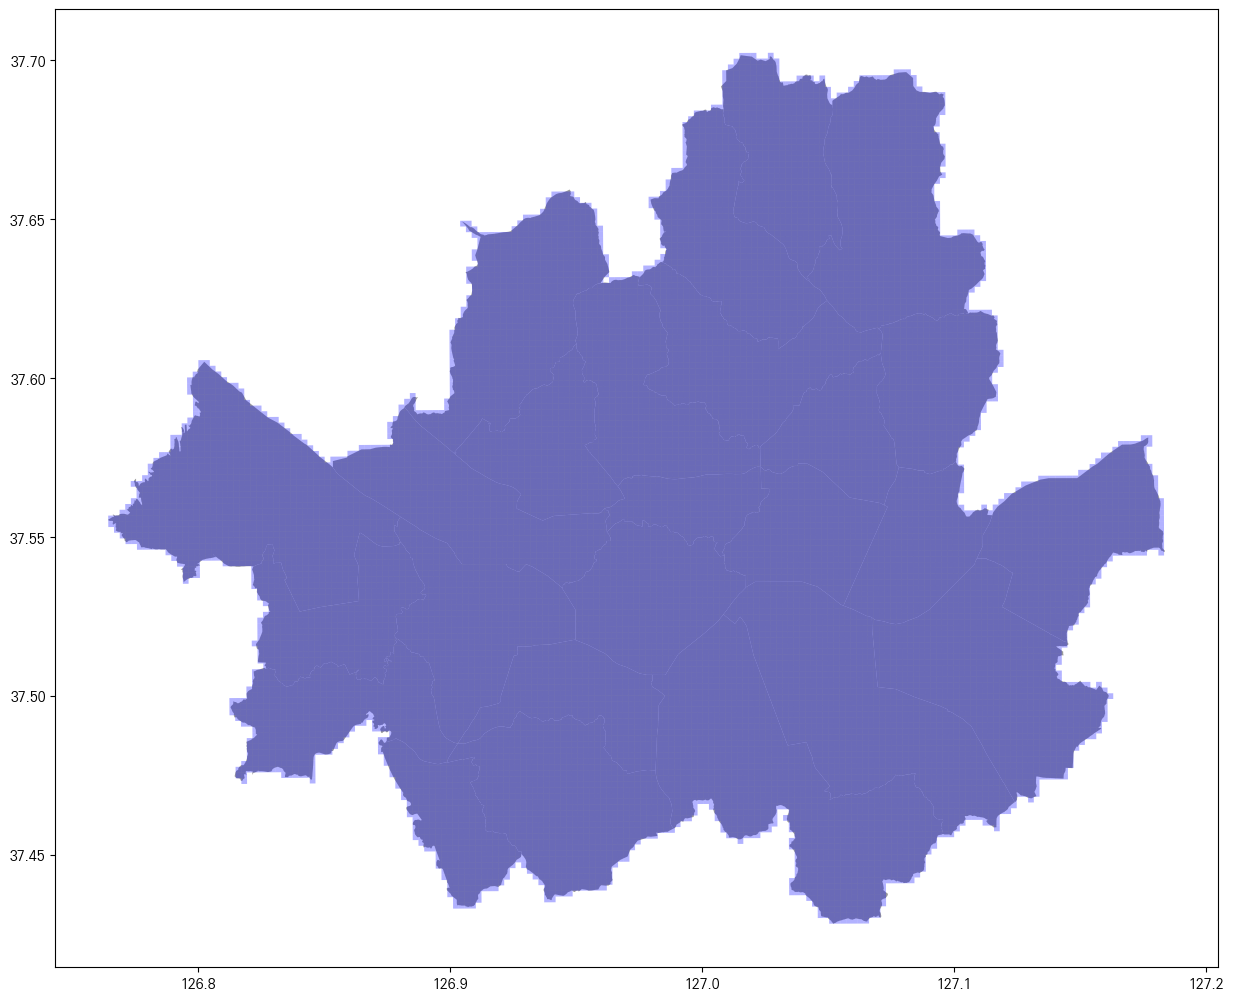

In [301]:
# 격자 Polygon 생성
new_grid_polygons = []
for x in tqdm(x_coords):
    for y in y_coords:
        new_grid_polygons.append(box(x, y, x + grid_size, y + grid_size))

# 격자들을 GeoDataFrame으로 변환
new_grid_gdf = gpd.GeoDataFrame({'geometry': new_grid_polygons})
new_grid_gdf = new_grid_gdf.set_crs(epsg=5179)
threshold = 0.1

def filter_grid_by_intersection(grid, polygon, threshold):
    intersection = grid.intersection(polygon)
    if intersection.is_empty:
        return False
    intersection_area = intersection.area
    grid_area = grid.area
    return (intersection_area / grid_area) >= threshold

new_grid_gdf['intersection'] = new_grid_gdf.geometry.apply(lambda x: filter_grid_by_intersection(x, seoul_polygon.unary_union, threshold))
new_grid_gdf = new_grid_gdf[new_grid_gdf['intersection']].drop(columns=['intersection'])
new_grid_gdf = new_grid_gdf.to_crs(epsg=4326)

display(new_grid_gdf.shape[0], new_grid_gdf.head())

fix, ax = plt.subplots(figsize=(15,15))
sgg[sgg['SIG_CD']<'20000'].plot(ax=ax,alpha=0.8,color='gray')
new_grid_gdf.plot(ax=ax,alpha=0.3,color='blue')

new_grid_gdf.reset_index(drop=True,inplace=True)
new_grid_gdf.to_file('../GIS/result/seoul_grid_200m.shp', driver='ESRI Shapefile', index=False )

In [302]:
new_grid_gdf

,geometry
0,"POLYGON ((126.76677 37.55306, 126.76675 37.554..."
1,"POLYGON ((126.76675 37.55486, 126.76674 37.556..."
2,"POLYGON ((126.76905 37.55127, 126.76904 37.553..."
3,"POLYGON ((126.76904 37.55307, 126.76902 37.554..."
4,"POLYGON ((126.76902 37.55488, 126.769 37.55668..."
...,...
15465,"POLYGON ((127.1834 37.55311, 127.18339 37.5549..."
15466,"POLYGON ((127.18339 37.55491, 127.18338 37.556..."
15467,"POLYGON ((127.18338 37.55671, 127.18337 37.558..."
15468,"POLYGON ((127.18337 37.55852, 127.18337 37.560..."


## 시군구 이름 입히기

In [296]:
seoul_sgg = sgg[sgg['SIG_CD'] < '20000']

In [357]:
# new_grid_gdf에 고유 ID 추가
new_grid_gdf['gid'] = new_grid_gdf.index

# 교차 면적 계산 (intersection) - 이미 gid가 포함된 상태로 반환됨
intersection_gdf = gpd.overlay(new_grid_gdf, seoul_sgg, how='intersection')

# 교차 면적 계산
intersection_gdf['area'] = intersection_gdf.geometry.area

# 각 격자에서 가장 큰 면적을 차지하는 시군구 선택
max_area_sgg = (intersection_gdf.groupby('gid')
                .apply(lambda g: g.loc[g['area'].idxmax(), ['gid', 'SIG_KOR_NM']])
                .reset_index(drop=True))

# 원래 격자에 시군구 이름을 바로 추가 (gid 기준으로 join)
new_grid_gdf = new_grid_gdf.join(max_area_sgg.set_index('gid'), on='gid')

new_grid_gdf.to_file('../GIS/result/seoul_grid_200m.shp', driver='ESRI Shapefile', index=False)

/tmp/ipykernel_164864/2136751004.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection_gdf['area'] = intersection_gdf.geometry.area
/tmp/ipykernel_164864/2136751004.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g['area'].idxmax(), ['gid', 'SIG_KOR_NM']])


In [360]:
new_grid_gdf

,geometry,gid,SIG_KOR_NM
0,"POLYGON ((126.76677 37.55306, 126.76675 37.554...",0,강서구
1,"POLYGON ((126.76675 37.55486, 126.76674 37.556...",1,강서구
2,"POLYGON ((126.76905 37.55127, 126.76904 37.553...",2,강서구
3,"POLYGON ((126.76904 37.55307, 126.76902 37.554...",3,강서구
4,"POLYGON ((126.76902 37.55488, 126.769 37.55668...",4,강서구
...,...,...,...
15465,"POLYGON ((127.1834 37.55311, 127.18339 37.5549...",15465,강동구
15466,"POLYGON ((127.18339 37.55491, 127.18338 37.556...",15466,강동구
15467,"POLYGON ((127.18338 37.55671, 127.18337 37.558...",15467,강동구
15468,"POLYGON ((127.18337 37.55852, 127.18337 37.560...",15468,강동구


<Axes: >

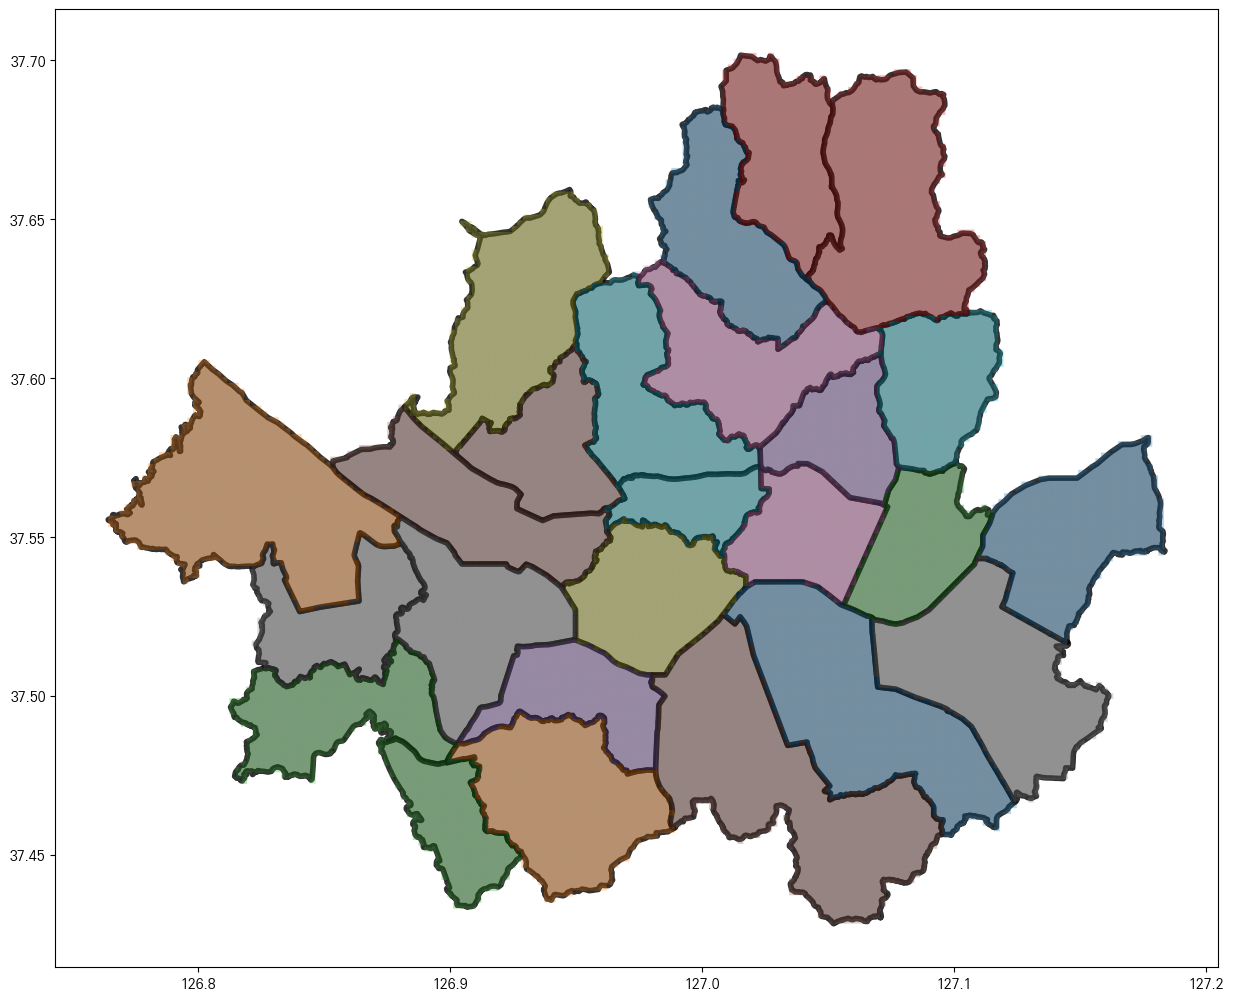

In [344]:
fix, ax = plt.subplots(figsize=(15,15))
sgg[sgg['SIG_CD']<'20000'].plot(ax=ax,alpha=0.8,color='gray',linewidth=4,edgecolor='black')
new_grid_gdf[new_grid_gdf].plot(ax=ax,alpha=0.3,column='SIG_KOR_NM')

In [353]:
new_grid_gdf

,geometry,gid,SIG_KOR_NM
0,"POLYGON ((126.76677 37.55306, 126.76675 37.554...",0,강서구
1,"POLYGON ((126.76675 37.55486, 126.76674 37.556...",1,강서구
2,"POLYGON ((126.76905 37.55127, 126.76904 37.553...",2,강서구
3,"POLYGON ((126.76904 37.55307, 126.76902 37.554...",3,강서구
4,"POLYGON ((126.76902 37.55488, 126.769 37.55668...",4,강서구
...,...,...,...
15465,"POLYGON ((127.1834 37.55311, 127.18339 37.5549...",15465,강동구
15466,"POLYGON ((127.18339 37.55491, 127.18338 37.556...",15466,강동구
15467,"POLYGON ((127.18338 37.55671, 127.18337 37.558...",15467,강동구
15468,"POLYGON ((127.18337 37.55852, 127.18337 37.560...",15468,강동구


In [363]:
sgg

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((127.00864 37.58047, 127.00871 37.580..."
1,11140,Jung-gu,중구,"POLYGON ((127.02314 37.57196, 127.02336 37.571..."
2,11170,Yongsan-gu,용산구,"POLYGON ((126.96918 37.55566, 126.96917 37.554..."
3,11200,Seongdong-gu,성동구,"POLYGON ((127.04341 37.57234, 127.04524 37.571..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((127.10166 37.5724, 127.10224 37.5721..."
...,...,...,...,...
245,51790,Hwacheon-gun,화천군,"POLYGON ((127.81765 38.28798, 127.81962 38.287..."
246,51800,Yanggu-gun,양구군,"MULTIPOLYGON (((128.0305 38.29128, 128.03055 3..."
247,51810,Inje-gun,인제군,"POLYGON ((127.97751 37.95707, 127.97872 37.957..."
248,51820,Goseong-gun,고성군,"MULTIPOLYGON (((128.54881 38.30195, 128.54881 ..."


### 전국을 한번에 만들어볼까?

In [84]:
inte_sgg

,SIDO_CD,SIDO_NM,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11,서울특별시,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11,서울특별시,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11,서울특별시,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11,서울특별시,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11,서울특별시,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.25, 964875.565 19..."
...,...,...,...,...,...,...
245,51,강원특별자치도,51790,Hwacheon-gun,화천군,"POLYGON ((1027779.614 2032000.017, 1027951.841..."
246,51,강원특별자치도,51800,Yanggu-gun,양구군,"MULTIPOLYGON (((1046391.747 2032451.649, 10463..."
247,51,강원특별자치도,51810,Inje-gun,인제군,"POLYGON ((1041948.853 1995343.843, 1042054.076..."
248,51,강원특별자치도,51820,Goseong-gun,고성군,"MULTIPOLYGON (((1091705.056 2034023.203, 10917..."


In [117]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from tqdm import tqdm
import pandas as pd

def create_grid(geodf, grid_size=200, crs='EPSG:5179'):
    """
    주어진 GeoDataFrame의 경계를 기준으로 grid 생성
    """
    print("Grid 생성 시작...", flush=True)
    minx, miny, maxx, maxy = geodf.total_bounds
    cols = np.arange(minx, maxx, grid_size)
    rows = np.arange(miny, maxy, grid_size)
    
    grid_cells = []
    for x in tqdm(cols, desc="열 생성 진행"):
        for y in rows:
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))
    
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    print(f"Grid 생성 완료. 총 {len(grid)}개의 셀 생성.", flush=True)
    return grid

def filter_grid_by_polygon(grid, geodf, threshold=0.01):
    """
    grid에서 지정된 polygon과 겹치는 셀만 필터링
    그리고 가장 많은 영역을 차지하는 시군구 정보를 각 격자에 할당
    """
    print("Polygon 필터링 시작...", flush=True)
    
    # 격자와 시군구 간의 공간 결합 (교차하는 경우만 남김)
    filtered_grid = gpd.sjoin(grid, geodf, how='inner', predicate='intersects')
    print(f"필터링된 grid 수: {len(filtered_grid)}", flush=True)
    
    # 가장 많은 영역을 차지하는 시군구 정보 할당
    def assign_largest_area_info(row, geodf):
        intersected = geodf[geodf.intersects(row.geometry)]
        intersected['area'] = intersected.intersection(row.geometry).area
        
        # 가장 넓은 면적을 차지하는 시군구의 정보를 할당
        largest_area_row = intersected.loc[intersected['area'].idxmax()]
        return largest_area_row[['SIDO_CD', 'SIDO_NM', 'SIG_CD', 'SIG_KOR_NM']]
    
    print("Grid에 가장 넓은 시군구 정보 할당 중...", flush=True)
    grid_info = filtered_grid.apply(assign_largest_area_info, axis=1, geodf=geodf)
    
    # 격자에 시군구 정보 결합
    filtered_grid[['SIDO_CD', 'SIDO_NM', 'SIG_CD', 'SIG_KOR_NM']] = grid_info
    
    # 불필요한 컬럼 제거 및 geometry 컬럼을 마지막으로 이동
    filtered_grid = filtered_grid.drop(columns=['index_right', 'SIG_ENG_NM'], errors='ignore')
    filtered_grid = filtered_grid[[col for col in filtered_grid.columns if col != 'geometry'] + ['geometry']]
    
    print("격자 정보 할당 완료.", flush=True)
    
    return filtered_grid

def process_sgg(geodf, target_sgg=None, grid_size=200, crs='EPSG:5179', threshold=0.01):
    """
    시군구별로 grid 생성 후 필터링
    target_sgg: 처리할 시군구 리스트 (None인 경우 전체 처리)
    """
    if target_sgg:
        print(f"선택된 시군구: {target_sgg}", flush=True)
        geodf = geodf[geodf['SIG_KOR_NM'].isin(target_sgg)]
    else:
        # target_sgg가 없는 경우, 전체 시군구 처리 로그 출력
        print(f"전체 시군구 처리 시작: 총 {len(geodf['SIG_KOR_NM'].unique())}개 시군구", flush=True)
        for sgg in geodf['SIG_KOR_NM'].unique():
            print(f"{sgg} 처리 중...", flush=True)
    
    grid = create_grid(geodf, grid_size, crs)
    filtered_grid = filter_grid_by_polygon(grid, geodf, threshold)
    print("시군구 처리 완료.", flush=True)
    return filtered_grid

In [126]:
# # 샘플 시군구 처리 (수원시 4개 구)
# target_sgg = ['화성시']
# filtered_grid = process_sgg(inte_sgg, target_sgg, grid_size=200)

# 전국 단위 처리
full_grid = process_sgg(inte_sgg, grid_size=200)


전체 시군구 처리 시작: 총 228개 시군구
종로구 처리 중...
중구 처리 중...
용산구 처리 중...
성동구 처리 중...
광진구 처리 중...
동대문구 처리 중...
중랑구 처리 중...
성북구 처리 중...
강북구 처리 중...
도봉구 처리 중...
노원구 처리 중...
은평구 처리 중...
서대문구 처리 중...
마포구 처리 중...
양천구 처리 중...
강서구 처리 중...
구로구 처리 중...
금천구 처리 중...
영등포구 처리 중...
동작구 처리 중...
관악구 처리 중...
서초구 처리 중...
강남구 처리 중...
송파구 처리 중...
강동구 처리 중...
서구 처리 중...
동구 처리 중...
영도구 처리 중...
부산진구 처리 중...
동래구 처리 중...
남구 처리 중...
북구 처리 중...
해운대구 처리 중...
사하구 처리 중...
금정구 처리 중...
연제구 처리 중...
수영구 처리 중...
사상구 처리 중...
기장군 처리 중...
수성구 처리 중...
달서구 처리 중...
달성군 처리 중...
군위군 처리 중...
미추홀구 처리 중...
연수구 처리 중...
남동구 처리 중...
부평구 처리 중...
계양구 처리 중...
강화군 처리 중...
옹진군 처리 중...
광산구 처리 중...
유성구 처리 중...
대덕구 처리 중...
울주군 처리 중...
세종특별자치시 처리 중...
수원시 장안구 처리 중...
수원시 권선구 처리 중...
수원시 팔달구 처리 중...
수원시 영통구 처리 중...
성남시 수정구 처리 중...
성남시 중원구 처리 중...
성남시 분당구 처리 중...
의정부시 처리 중...
안양시 만안구 처리 중...
안양시 동안구 처리 중...
부천시 처리 중...
광명시 처리 중...
평택시 처리 중...
동두천시 처리 중...
안산시 상록구 처리 중...
안산시 단원구 처리 중...
고양시 덕양구 처리 중...
고양시 일산동구 처리 중...
고양시 일산서구 처리 중...
과천시 처리 중...
구리시 처리 중..

열 생성 진행: 100%|██████████| 3210/3210 [02:47<00:00, 19.14it/s]


Grid 생성 완료. 총 9787290개의 셀 생성.
Polygon 필터링 시작...
필터링된 grid 수: 2616895
Grid에 가장 넓은 시군구 정보 할당 중...
격자 정보 할당 완료.
시군구 처리 완료.


In [137]:
full_grid.sort_values(['SIDO_CD','SIG_CD'], ascending=[True,True], inplace=True)
full_grid.reset_index(drop=True,inplace=True)
full_grid['gid'] = full_grid.index

In [139]:
full_grid.to_file('../GIS/result/Korea_Grid_200m_5179.shp', index=False)

In [144]:
new_seoul = full_grid[full_grid['SIDO_CD'] == '11']

In [145]:
old_seoul = gpd.read_file('../GIS/result/seoul_grid_200m.shp')

In [149]:
new_seoul.to_crs(epsg=4326,inplace=True)
old_seoul.to_crs(epsg=4326,inplace=True)

In [152]:
missing_in_old = new_seoul.loc[~new_seoul['geometry'].apply(lambda x: old_seoul['geometry'].apply(lambda y: x.equals_exact(y, tolerance=1e-6)).any())]

# 결과 출력
print(f"새 결과에서 이전 결과에 없는 격자: {len(missing_in_old)}개")

# 추가된 격자의 정보 확인 (필요한 경우)
missing_in_old.head()  # 처음 몇 개의 결과 미리보기

새 결과에서 이전 결과에 없는 격자: 17165개


,SIDO_CD,SIDO_NM,SIG_CD,SIG_KOR_NM,geometry,gid
0,11,서울특별시,11110,종로구,"POLYGON ((126.95052 37.62156, 126.95051 37.623...",0
1,11,서울특별시,11110,종로구,"POLYGON ((126.95052 37.62156, 126.95051 37.623...",1
2,11,서울특별시,11110,종로구,"POLYGON ((126.95051 37.62336, 126.9505 37.6251...",2
3,11,서울특별시,11110,종로구,"POLYGON ((126.95051 37.62336, 126.9505 37.6251...",3
4,11,서울특별시,11110,종로구,"POLYGON ((126.95289 37.60714, 126.95288 37.608...",4


<Axes: >

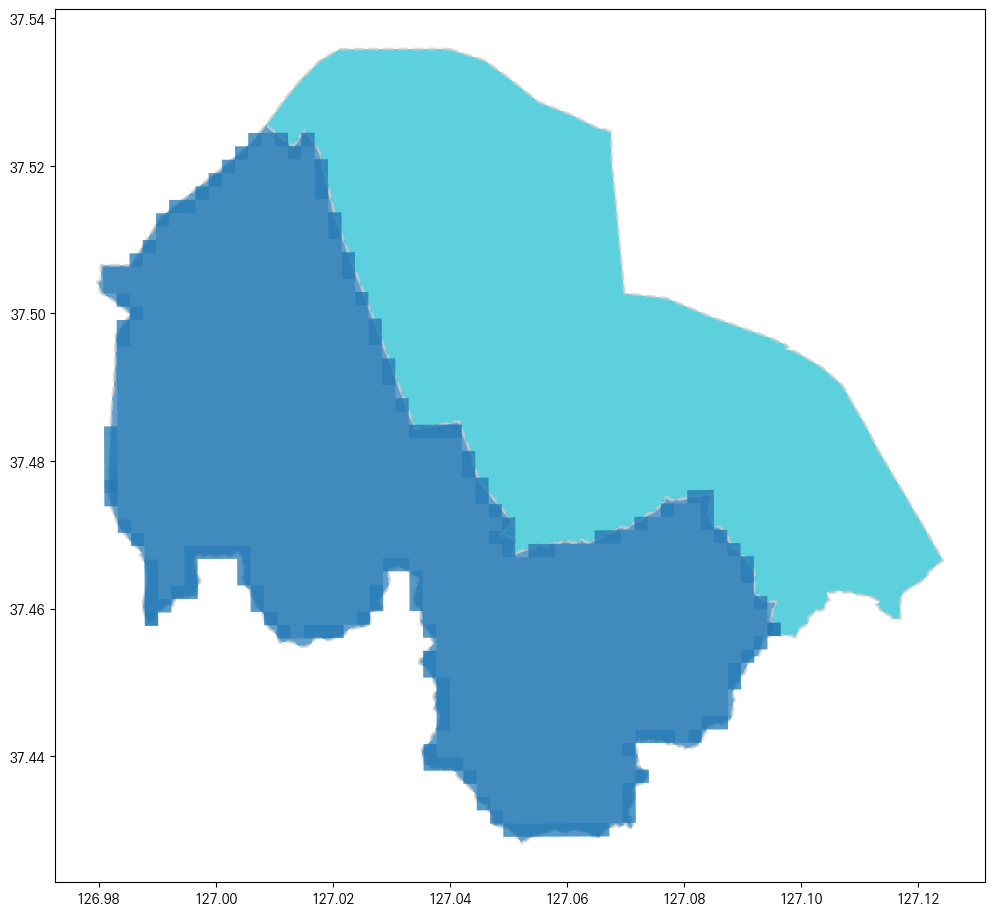

In [204]:
fig, ax = plt.subplots(figsize=(12,12))
sgg[sgg['SIG_KOR_NM'].isin(['서초구','강남구'])].to_crs(epsg=4326).plot(ax=ax, alpha = 0.7,linestyle='--',edgecolor='0.8',linewidth = 2,column='SIG_CD')
new_seoul[new_seoul['SIG_KOR_NM'].isin(['서초구'])].plot(ax=ax, column='SIG_CD',alpha=0.5)
#old_seoul[old_seoul['SIG_KOR_NM'] == '서초구'].plot(ax=ax, color = 'red', alpha = 0.1)